# An introduction to overfitting

In the previous lab we have designed an MLP network for image classification, and we have trained it in a rather straightforward fashion, which in practice is a bit risky. Indeed, our model was designed and trained for minimizing the loss on the training set for a given number of epochs. As such, we might end up with a model that is very good at predicting the data from this training set, but is unable to *generalize* to unseen/new data (e.g., from the test set). This behavior is called **overfitting** and is a major problem in deep learning, wich we adress in this script.

<center><a href="https://medium.com/geekculture/investigating-underfitting-and-overfitting-70382835e45c">
    <img src="https://miro.medium.com/max/1400/1*OeJVQ7sEvOJGxfGSCpbzyA.png" width="600"></a></center>
    
More specifically, we study two common sources of overfitting:

- Training for too many epochs.
- Using an over-parametrized (i.e., too large) model (this corresponds to the figure above).

In [144]:
import torch 
import torchvision
import torch.nn as nn
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import random
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, transform
from torch.utils.data import DataLoader, random_split, Subset
import copy

## Dataset and model

As in the previous lab, we work with the MNIST dataset and we use a simple 3-layer MLP. We provide the code below.

In [145]:
# Define the data repository
data_dir = 'data/'

# Load the MNIST training dataset (in this script we don't need the test set), and take a small subset
data_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize((0.1307,), (0.3081,))])
train_data = torchvision.datasets.MNIST(data_dir, train=True, download=True, transform=data_transforms)
num_classes = len(train_data.classes)
train_data = Subset(train_data, torch.arange(400))

In [146]:
# MLP classifier
class MLPClassif(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLPClassif, self).__init__()
        self.input_layer = nn.Sequential(nn.Linear(input_size, hidden_size), nn.ReLU())
        self.hidden_layer = nn.Sequential(nn.Linear(hidden_size, hidden_size), nn.ReLU())
        self.output_layer = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        y = self.input_layer(x)
        y = self.hidden_layer(y)
        out = self.output_layer(y)
        return out
    
    
# Initialization function
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight.data)
        if m.bias is not None:
            m.bias.data.fill_(0.01)

## The validation set

Until now, we have splitted our data into two sets: training and testing. A key ingredient in avoiding overfitting is the usage of an additional *validation* (or *development*) set. The data is then split into:

- the *training set*, used to train the model's parameters.
- the *validation set*, used to evaluate the capacity of the model to generalize to unseen data.
- the *test set*, used to compare different baselines / methods after training.

<center><a href="https://www.v7labs.com/blog/train-validation-test-set">
    <img src="https://assets-global.website-files.com/5d7b77b063a9066d83e1209c/61568656a13218cdde7f6166_training-data-validation-test.png" width="400"></a></center>

In [147]:
# Define the validation set by splitting the training data into 2 subsets (80% training and 20% validation)
n_train_examples = int(len(train_data)*0.8)
n_valid_examples = len(train_data) - n_train_examples
torch.manual_seed(0)
train_data, valid_data = random_split(train_data, [n_train_examples, n_valid_examples])
print(len(train_data), len(valid_data))

# Create the corresponding dataloaders
batch_size = 8
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_dataloader = DataLoader(valid_data, batch_size=batch_size)

320 80


## Training with validation

A first simple approach to avoid overfitting is to monitor the performance of the model on the validation set over epochs when training. At each epoch we compute the loss on the validation set, and check how it behaves: if the validation loss decreases, then we can continue training. Conversely, if the validation loss increases, it means the model has overfitted, so we need to stop training. Here, we run training with a specified maximum number of epochs, and we save the model yielding the lowest validation loss as the optimal/best one.

<center><a href="https://theaisummer.com/regularization/">
    <img src="https://theaisummer.com/static/7a6353ed78b045f32e4ac39b0b4d66d2/a878e/early-stopping.png" width="400"></a></center>
    

**Note**: In practice, instead of computing the validation *loss/error* (which ideally should decrease), we can compute the validation *accuracy* (which ideally should increase). The concept is the same, but it is usually better to use a validation metric that is as close as possible or equal to the test metric (here: accuracy).

In [148]:
# Evaluation function
def eval_mlp_classifier(model, eval_dataloader):
    
    # Set the model in 'evaluation' mode (this disables some layers (batch norm, dropout...) which are not needed when testing)
    model.eval() 

    # In evaluation phase, we don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        # initialize the total and correct number of labels to compute the accuracy
        correct_labels = 0
        total_labels = 0
        
        # Iterate over the dataset using the dataloader
        for images, labels in eval_dataloader:

            # Get the predicted labels
            images = images.reshape(images.shape[0], -1)
            y_predicted = model(images)
            
            # To get the predicted labels, we need to get the max over all possible classes
            _, label_predicted = torch.max(y_predicted.data, 1)
            
            # Compute accuracy: count the total number of samples, and the correct labels (compare the true and predicted labels)
            total_labels += labels.size(0)
            correct_labels += (label_predicted == labels).sum().item()
    
    accuracy = 100 * correct_labels / total_labels
    
    return accuracy

The training function is very similar to what we did in the previous lab, so feel free to reuse it. There are two main differences:

- Instead of SGD, we we use the [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) optimizer, which is a more efficient algorithm (the pytorch code is very similar though: you just need to provide the model's parameters and the learning rate).
- At the end of each epoch, compute the accuracy on the validation set (use the provided eval function): if the accuracy is increasing, then store the current model as the optimal one.

In [149]:
def train_val_mlp_classifier(model, train_dataloader, valid_dataloader, num_epochs, loss_fn, learning_rate, verbose=True):

    # Make a copy of the model (avoid changing the model outside this function)
    model_tr = copy.deepcopy(model)

    # Set the model in 'training' mode (ensures all parameters' gradients are computed - it's like setting 'requires_grad=True' for all parameters)
    model_tr.train()

    # Define the optimizer
    optimizer = torch.optim.Adam(model_tr.parameters(), lr=learning_rate) # USE THE ADAM OPTIMIZER

    # Initialize a list for storing the training loss over epochs
    train_losses = []

    acc =[]

    # Initialize variables to keep track of the best model and best validation loss
    best_model = None
    best_acc = 0 # WHY START AT INF INSTEAD OF 0 ?

    # Training loop
    for epoch in range(num_epochs):

        # Initialize the training loss for the current epoch
        tr_loss = 0

        # Iterate over batches using the dataloader
        for batch_index, (images, labels) in enumerate(train_dataloader):

            # TO DO: write the training procedure for each batch. This should consist of:
            # - vectorizing the images (size should be (batch_size, input_size))
            # - calculate the predicted labels from the vectorized images using 'model_tr'
            # - using loss_fn, calculate the 'loss' between the predicted and true labels
            # - set the optimizer gradients at 0 for safety
            # - compute the gradients (use the 'backward' method on 'loss')
            # - apply the gradient descent algorithm (perform a step of the optimizer)

            # Prepare the inputs and labels
            images = images.reshape(len(images), -1)

            # Forward pass
            labels_predicted = model_tr(images)
            loss = loss_fn(labels_predicted, labels)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update the current epoch loss
            # Note that 'loss.item()' is the loss averaged over the batch, so multiply it with the current batch size to get the total batch loss
            tr_loss += loss.item() * 8

        # At the end of each epoch, get the average training loss and store it
        tr_loss = tr_loss/len(train_dataloader.dataset)
        train_losses.append(tr_loss)

        # At the end of each epoch, get the accuracy and store it
        evalIJS = eval_mlp_classifier(model_tr,valid_dataloader)
        acc.append(evalIJS)

        # If the current model has a lower validation loss, update the best model
        if evalIJS > best_acc:
            best_acc = evalIJS
            best_model = copy.deepcopy(model_tr)


        if verbose:
            print('Epoch [{}/{}], Training loss: {:.4f}, Accuracy: {:.4f}'.format(epoch+1, num_epochs, tr_loss, evalIJS))

    return best_model, train_losses, acc

In [150]:
# Instanciate the network and initialize the parameters for reproducibility
input_size = train_data[0][0][0].shape[0]*train_data[0][0][0].shape[1]
hidden_size = 32
output_size = num_classes
model = MLPClassif(input_size, hidden_size, output_size)
torch.manual_seed(0)
model.apply(init_weights)

# Training
loss_fn = nn.CrossEntropyLoss()
num_epochs = 50
learning_rate = 0.001
model_opt, train_losses, val_accuracies = train_val_mlp_classifier(model, train_dataloader, valid_dataloader, num_epochs, loss_fn, learning_rate)

Epoch [1/50], Training loss: 1.8052, Accuracy: 62.5000
Epoch [2/50], Training loss: 0.8184, Accuracy: 82.5000
Epoch [3/50], Training loss: 0.4151, Accuracy: 80.0000
Epoch [4/50], Training loss: 0.2439, Accuracy: 83.7500
Epoch [5/50], Training loss: 0.1672, Accuracy: 88.7500
Epoch [6/50], Training loss: 0.1021, Accuracy: 87.5000
Epoch [7/50], Training loss: 0.0630, Accuracy: 88.7500
Epoch [8/50], Training loss: 0.0473, Accuracy: 88.7500
Epoch [9/50], Training loss: 0.0344, Accuracy: 87.5000
Epoch [10/50], Training loss: 0.0269, Accuracy: 88.7500
Epoch [11/50], Training loss: 0.0215, Accuracy: 88.7500
Epoch [12/50], Training loss: 0.0166, Accuracy: 88.7500
Epoch [13/50], Training loss: 0.0136, Accuracy: 88.7500
Epoch [14/50], Training loss: 0.0117, Accuracy: 88.7500
Epoch [15/50], Training loss: 0.0102, Accuracy: 88.7500
Epoch [16/50], Training loss: 0.0089, Accuracy: 88.7500
Epoch [17/50], Training loss: 0.0077, Accuracy: 88.7500
Epoch [18/50], Training loss: 0.0067, Accuracy: 88.7500
E

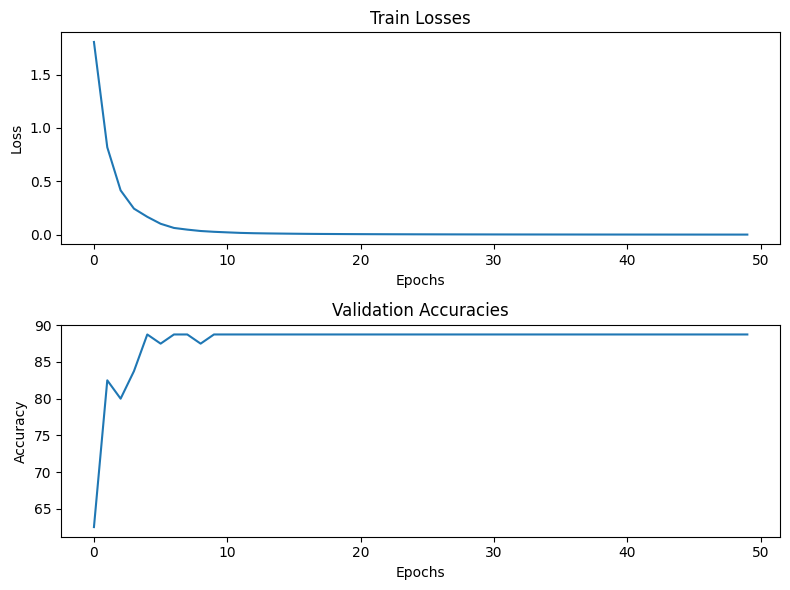

In [151]:
# TO DO: plot the training loss and validation accuracy (on two different subplots)
# Create a single figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

# Plot the first graph on the first subplot
ax1.plot(train_losses)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Train Losses')

# Plot the second graph on the second subplot
ax2.plot(val_accuracies)
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Validation Accuracies')

# Adjust spacing between subplots
plt.tight_layout()

# Show the combined graph
plt.show()

<span style="color:red">**Q1**</span> Put the plot above (training loss and validation accuracy) in your report. What do you remark? Is it beneficial to monitor the validation accuracy?

**Note**: We conducted training for all epochs, and we simply recorded the best performing model. Proper early stopping would mean that we interrupt training when no improvement is observed after the best validation loss has been obtained (this number of epochs is called a *patience* parameter, since it corresponds to the "waiting time" after the best validation score is obtained).
This allows to reduce the computational time in addition to yielding the best model.


## Adjusting the model's capacity

The number of parameters in the network (i.e., the model's *capacity*) is expected to have a major impact on performance. Too few parameters might yield bad performance (underfitting), while too many might hamper the ability of the network to generalize (overfitting).


<center><a href="https://classic.d2l.ai/chapter_multilayer-perceptrons/underfit-overfit.html">
    <img src="https://classic.d2l.ai/_images/capacity-vs-error.svg" width="400"></a></center>
    

Here, we study it by varying the number of hidden layers and checking how the validation accuracy behaves.

Below we consider a general classifier module, where the number of hidden layers is passed as an input parameter. To create and stack together several layers, we can use the [ModuleList](https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html) object, along with a simple loop.

In [152]:
# On this example, we stack 5 {Linear + Relu} layers
list_layer = nn.ModuleList([nn.Sequential(nn.Linear(10, 10), nn.ReLU()) for l in range(5)])
print(list_layer)

ModuleList(
  (0): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): ReLU()
  )
  (1): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): ReLU()
  )
  (3): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): ReLU()
  )
  (4): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): ReLU()
  )
)


In [153]:
# TO DO: write the MLP classifier class ('__init__' and 'forward' methods) with a variable number of hidden layers.
class MLPClassifVAR(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, hidden_layer_num):
        super(MLPClassifVAR, self).__init__()
        self.input_layer = nn.Sequential(nn.Linear(input_size, hidden_size), nn.ReLU())
        self.list_layer = nn.ModuleList([nn.Sequential(nn.Linear(hidden_size, hidden_size), nn.ReLU()) for l in range(hidden_layer_num)])
        self.output_layer = nn.Linear(hidden_size, output_size)
        self.hidden_layer_num = hidden_layer_num

    def forward(self, x):
        y = self.input_layer(x)
        # for k in range(self.hidden_layer_num):
        #    y = self.list_layer[k](y)
        for layer in self.list_layer:
            y = layer(y)
        out = self.output_layer(y)
        return out

    def get_layer(self, layer_idx):
        if layer_idx == 0:
            return self.input_layer
        elif 0 < layer_idx <= self.hidden_layer_num:
            return self.list_layer[layer_idx - 1]
        elif layer_idx == self.hidden_layer_num + 1:
            return self.output_layer
        else:
            raise IndexError("Layer index out of range")

In [154]:
# TO DO:
# - Define the general parameters of the MLP classifier model and training (same as before)
# Instanciate the network and initialize the parameters for reproducibility
input_size = train_data[0][0][0].shape[0]*train_data[0][0][0].shape[1]
hidden_size = 32
loss_fn = nn.CrossEntropyLoss()
num_epochs = 50
learning_rate = 0.001
output_size = num_classes
hidden_layer_num = [1,3,5]
max_accuracy = []
for hidden_layer_member in hidden_layer_num:
    model = MLPClassifVAR(input_size, hidden_size, output_size, hidden_layer_member)
    torch.manual_seed(0)
    model.apply(init_weights)
    # Training
    model_opt, train_losses, val_accuracies = train_val_mlp_classifier(model, train_dataloader, valid_dataloader, num_epochs, loss_fn, learning_rate)

    # Find the maximum accuracy value
    max_accuracy.append(max(val_accuracies))

print(max_accuracy)



# - For a number of hidden layers equal to 1, 3, and 5:
#      - Instanciate a model (remember to initialize the weights to ensure reproducibility)
#      - Train the model
#      - Get the maximum validation accuracy
# - Plot the max accuracy as a function of the number of hidden layers


Epoch [1/50], Training loss: 1.8052, Accuracy: 62.5000
Epoch [2/50], Training loss: 0.8184, Accuracy: 82.5000
Epoch [3/50], Training loss: 0.4151, Accuracy: 80.0000
Epoch [4/50], Training loss: 0.2439, Accuracy: 83.7500
Epoch [5/50], Training loss: 0.1672, Accuracy: 88.7500
Epoch [6/50], Training loss: 0.1021, Accuracy: 87.5000
Epoch [7/50], Training loss: 0.0630, Accuracy: 88.7500
Epoch [8/50], Training loss: 0.0473, Accuracy: 88.7500
Epoch [9/50], Training loss: 0.0344, Accuracy: 87.5000
Epoch [10/50], Training loss: 0.0269, Accuracy: 88.7500
Epoch [11/50], Training loss: 0.0215, Accuracy: 88.7500
Epoch [12/50], Training loss: 0.0166, Accuracy: 88.7500
Epoch [13/50], Training loss: 0.0136, Accuracy: 88.7500
Epoch [14/50], Training loss: 0.0117, Accuracy: 88.7500
Epoch [15/50], Training loss: 0.0102, Accuracy: 88.7500
Epoch [16/50], Training loss: 0.0089, Accuracy: 88.7500
Epoch [17/50], Training loss: 0.0077, Accuracy: 88.7500
Epoch [18/50], Training loss: 0.0067, Accuracy: 88.7500
E

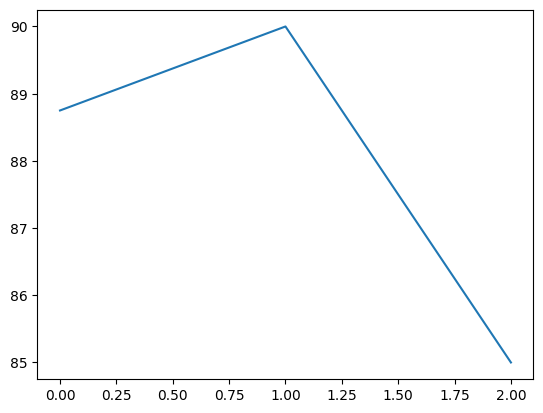

In [155]:
plt.plot(max_accuracy)

<span style="color:red">**Q2**</span> Put the plot above (test accuracy as a function of number of hidden layers) in your report. What do you observe? What's the best model / number of hidden layers to use?plot(